# apply instruments settings

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.optimize import curve_fit

In [108]:
# File path
# file_path = "output\\20240508_coherence_measurement\\m1fid_400.0nspihalf_32010.0nsrange_392.83877152204514freqactual_-1.0MHzdetune.pkl"
# file_path = "output\\20240508_coherence_measurement\\m1fid_400.0nspihalf_32010.0nsrange_392.8392714858055freqactual_-0.5MHzdetune.pkl"
file_path = "output\\20240508_coherence_measurement\\m1fid_400.0nspihalf_64010.0nsrange_392.83987149596214freqactual_0.1MHzdetune.pkl"
# Open the file in binary read mode
with open(file_path, 'rb') as f:
    # Read data from the file using pickle.load()
    data = pickle.load(f)

# Access your data variables
fid_dur = data['fid_dur']
freq_actual = data['freq_actual']
signal_av = data['signal_av']
background_av = data['background_av']
contrast = data['contrast']

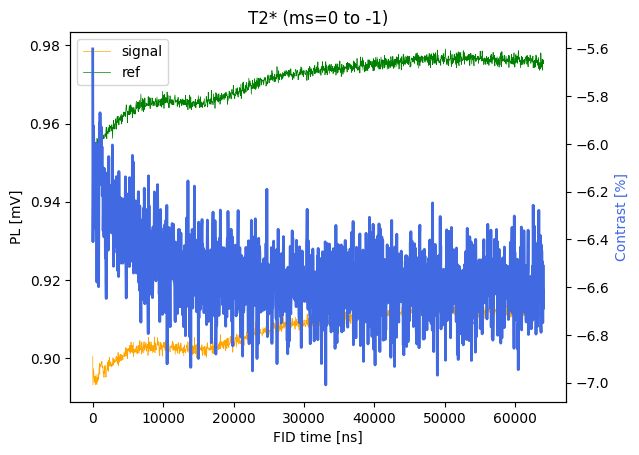

In [109]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
# ax1.plot(mw_dur, signal_av*1E3, linewidth=0.5, label="signal", color="orange")
# ax1.plot(mw_dur, background_av*1E3, linewidth=0.5, label="ref", color="green")
# ax2.plot(mw_dur, contrast*100.0, linewidth=2, label="contrast", color='royalblue')
idxstart = 0
idxend = len(fid_dur)
# idxend = 500
ax1.plot(fid_dur[idxstart:idxend], signal_av[idxstart:idxend]*1E3, linewidth=0.5, label="signal", color="orange")
ax1.plot(fid_dur[idxstart:idxend], background_av[idxstart:idxend]*1E3, linewidth=0.5, label="ref", color="green")
ax2.plot(fid_dur[idxstart:idxend], contrast[idxstart:idxend]*100.0, linewidth=2, label="contrast", color='royalblue')

ax1.set_xlabel("FID time [ns]")
ax1.set_ylabel("PL [mV]")
ax2.set_ylabel("Contrast [%]", color='royalblue')
ax1.legend(loc='best')
plt.title("T2* (ms=0 to -1)")
plt.savefig(f"{'.'.join(file_path.split('.')[0:-1])}.jpg")
plt.show()

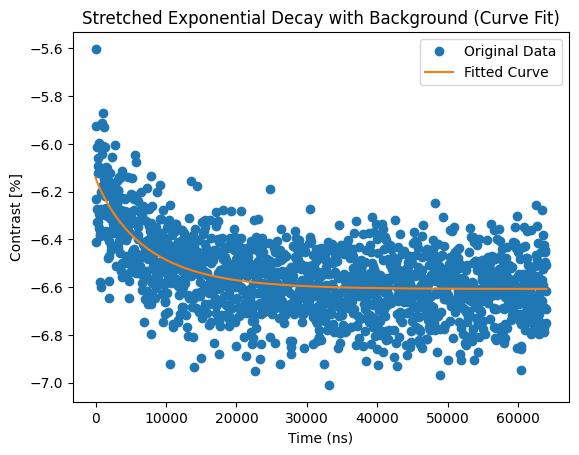

Fitted parameters:
A (amplitude): 0.004671085837543904
Tau (decay time): 7263.077987664179
Stretch factor (n): 0.9191085114601045
Background level (B): -0.06607455430455887


In [111]:
# Define stretched exponential decay with background
def stretched_exponential_with_background(t, A, tau, n, B):
    return A * np.exp(-(t / tau) ** n) + B

def exponential_with_background(t, A, tau, B):
    return stretched_exponential_with_background(t, A, tau, 1, B)

# Estimator for initial guess with background
def estimate_initial_guess_with_background(fid_dur, contrast):
    # Estimate amplitude from the initial drop relative to the background level
    background_guess = contrast[-1]
    A_guess = contrast[0] - background_guess
    
    # Ensure guesses are valid and within bounds
    A_guess = max(0, A_guess)  # Amplitude must be non-negative
    
    # Estimate tau by finding the time when the contrast is 1/e of its initial level above the background
    initial_fraction = 1 / np.exp(1)  # 1/e ≈ 0.37
    tau_guess = fid_dur[-1]  # Default to the last time point
    
    indices = np.where(contrast <= contrast[0] * initial_fraction)[0]
    if len(indices) > 0:
        tau_guess = fid_dur[indices[0]]
    
    tau_guess = max(0, tau_guess)  # Decay time must be non-negative
    
    # Guess stretch factor (n) and ensure it's within bounds
    n_guess = 1  # A common starting point
    n_guess = max(0, n_guess)  # Stretch factor should be non-negative

    return [A_guess, tau_guess, n_guess, background_guess]

# Get initial guesses
initial_guess = estimate_initial_guess_with_background(fid_dur, contrast)
# del initial_guess[2]


# Define parameter bounds for stability
bounds = ([0, 0, 0, -np.inf], [np.inf, np.max(fid_dur), 2, np.inf])  # Reasonable bounds for stability
# bounds = ([0, 0, -np.inf], [np.inf, np.max(fid_dur), np.inf])  # Reasonable bounds for stability


# Increase `maxfev` to allow more iterations
maxfev = 2000  # Adjust as needed

# Perform curve fitting
try:
    popt, pcov = curve_fit(
        stretched_exponential_with_background,
        fid_dur,
        contrast,
        p0=initial_guess,
        maxfev=maxfev,
        bounds=bounds,
    )

    # Get the fitted parameters
    A, tau, n, B = popt
    # A, tau, B = popt

    # Plot the original data and the fitted curve
    plt.figure()
    plt.plot(fid_dur, contrast*100.0, 'o', label='Original Data')  # Plot original data points
    plt.plot(fid_dur, stretched_exponential_with_background(fid_dur, *popt)*100.0, '-', label='Fitted Curve')  # Fitted curve
    plt.xlabel('Time (ns)')
    plt.ylabel('Contrast [%]')
    plt.title('Stretched Exponential Decay with Background (Curve Fit)')
    plt.legend()
    plt.show()

    # Output the fitted parameters
    print("Fitted parameters:")
    print(f"A (amplitude): {A}")
    print(f"Tau (decay time): {tau}")
    print(f"Stretch factor (n): {n}")
    print(f"Background level (B): {B}")

except ValueError as e:
    print(f"Curve fitting error: {e}")

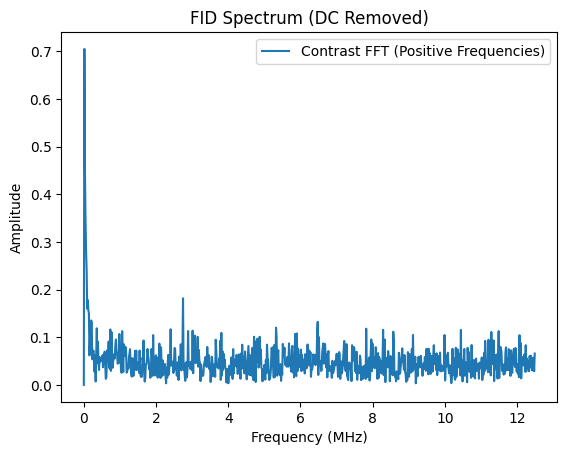

In [112]:
# Remove the DC component (constant offset) by subtracting the mean
contrast_centered = contrast - np.mean(contrast)

# Perform the FFT after removing DC
# Convert fid_dur from nanoseconds to seconds for correct frequency calculation
sampling_interval = (fid_dur[1] - fid_dur[0]) * 1e-3  # Convert ns to us

# Compute FFT and corresponding frequencies
contrast_fft = np.fft.fft(contrast_centered)
frequencies = np.fft.fftfreq(len(contrast_centered), sampling_interval)

# Filter out the negative frequencies
positive_frequencies = frequencies[frequencies >= 0]
positive_fft = contrast_fft[frequencies >= 0]

# Plot only the positive frequencies
plt.figure()
plt.plot(positive_frequencies, np.abs(positive_fft), label='Contrast FFT (Positive Frequencies)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Amplitude')
plt.title('FID Spectrum (DC Removed)')
plt.legend()
plt.savefig(f"{'.'.join(file_path.split('.')[0:-1])}_fft.jpg")

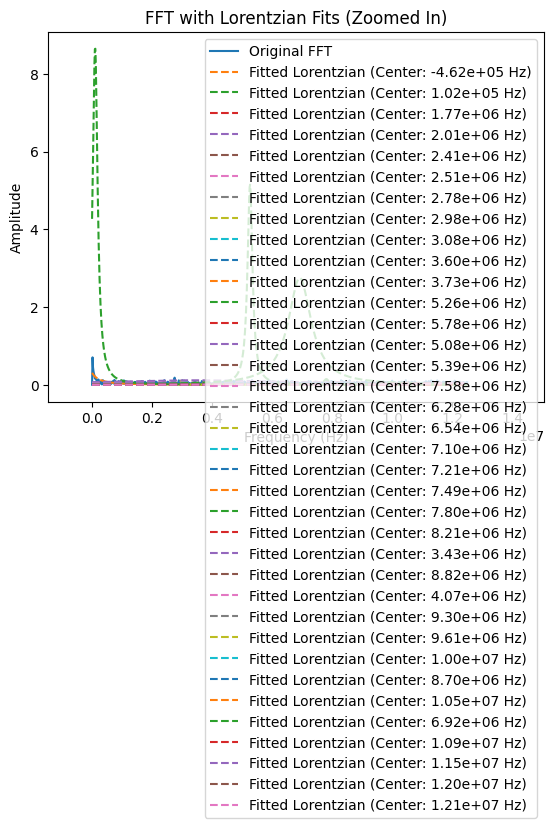

Fitted peak frequencies:
-4.62e+05 Hz
1.02e+05 Hz
1.77e+06 Hz
2.01e+06 Hz
2.41e+06 Hz
2.51e+06 Hz
2.78e+06 Hz
2.98e+06 Hz
3.08e+06 Hz
3.60e+06 Hz
3.73e+06 Hz
5.26e+06 Hz
5.78e+06 Hz
5.08e+06 Hz
5.39e+06 Hz
7.58e+06 Hz
6.28e+06 Hz
6.54e+06 Hz
7.10e+06 Hz
7.21e+06 Hz
7.49e+06 Hz
7.80e+06 Hz
8.21e+06 Hz
3.43e+06 Hz
8.82e+06 Hz
4.07e+06 Hz
9.30e+06 Hz
9.61e+06 Hz
1.00e+07 Hz
8.70e+06 Hz
1.05e+07 Hz
6.92e+06 Hz
1.09e+07 Hz
1.15e+07 Hz
1.20e+07 Hz
1.21e+07 Hz


: 

In [113]:
# Define Lorentzian function
def lorentzian(x, amplitude, center, width):
    return amplitude / (1.0 + ((x - center) / width) ** 2)

# Perform the FFT (with DC removal)
sampling_interval = (fid_dur[1] - fid_dur[0]) * 1e-9  # Convert ns to s
contrast_fft = np.fft.fft(contrast_centered)

# Get the positive frequencies and their FFT results
frequencies = np.fft.fftfreq(len(contrast_centered), sampling_interval)
positive_indices = frequencies >= 0
positive_frequencies = frequencies[positive_indices]
positive_fft = contrast_fft[positive_indices]

# Get the magnitude of the positive FFT
fft_magnitude = np.abs(positive_fft)

# Identify peak regions for fitting
threshold = 0.3 * np.max(fft_magnitude[15:])  # Relative threshold
peak_indices = list(np.array(np.where(fft_magnitude[15:] > threshold)[0]) + 15)

# Group peak indices to identify unique peaks and double their range
peak_groups = []
current_group = []

# Identify groups of peaks
for i in peak_indices:
    if not current_group:
        current_group.append(i)
    elif i - current_group[-1] <= 5:
        current_group.append(i)
    else:
        peak_groups.append(current_group)
        current_group = [i]

# Add any remaining group
if current_group:
    peak_groups.append(current_group)

# Extend each group by doubling its range
extended_peak_groups = []
for group in peak_groups:
    # Extend the start and end of each group by doubling its length
    start = max(0, group[0] - 2*len(group))  # Ensure it doesn't go below zero
    end = min(len(positive_frequencies) - 1, group[-1] + 2*len(group))  # Ensure it doesn't go out of bounds
    extended_peak_groups.append(list(range(start, end)))

# Fit Lorentzian to each extended peak group
fitted_peaks = []
plt.figure()
plt.plot(positive_frequencies, fft_magnitude, label="Original FFT")

# Increase maxfev for more complex fittings
maxfev = 2000  # Adjust as needed

# Iterate over each extended peak group for fitting
for group in extended_peak_groups:
    # Get the mid-point of the group as the initial guess for the center
    initial_center = positive_frequencies[group[len(group) // 2]]
    initial_amplitude = fft_magnitude[group[len(group) // 2]]
    initial_width = 1e6  # An initial guess for width

    try:
        # Perform curve fitting with constraints and bounds
        popt, _ = curve_fit(
            lorentzian,
            positive_frequencies[group],
            fft_magnitude[group],
            p0=[initial_amplitude, initial_center, initial_width],
            maxfev=maxfev,
            bounds=([0, initial_center - 5e6, 1e5], [np.inf, initial_center + 5e6, 1e7]),  # Constrained bounds
        )

        # Extract fitted parameters
        amplitude, center, width = popt
        fitted_peaks.append(center)

        # Plot the fitted Lorentzian curve
        plt.plot(
            positive_frequencies,
            lorentzian(positive_frequencies, amplitude, center, width),
            '--',
            label=f"Fitted Lorentzian (Center: {center:.2e} Hz)",
        )
    except RuntimeError:
        print(f"Could not fit Lorentzian for peak group centered at {initial_center:.2e} Hz")

# Zoom in to the fitted peak regions
peak_centers = np.array(fitted_peaks)
zoom_margin_lower = 1e6  # Adjust as needed for lower margin
zoom_margin_higher = 3e6  # Adjust as needed for upper margin

plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("FFT with Lorentzian Fits (Zoomed In)")
plt.legend()
plt.xlim(min(0, peak_centers.min() - zoom_margin_lower), peak_centers.max() + zoom_margin_higher)  # Set x-axis limits to zoom
plt.show()

# Output the fitted peak frequencies
print("Fitted peak frequencies:")
for peak in fitted_peaks:
    print(f"{peak:.2e} Hz")

In [ ]:
4